Notes:
 * run 12, evaluations for label S

In [1]:
import os

chkpt_root = '/mnt/tess/astronet/checkpoints/extended_20_run_12'
data_files = '/mnt/tess/astronet/tfrecords-20-val/*'
tces_file = '/mnt/tess/astronet/tces-v4-val.csv'

nruns = 10

def load_ensemble(chkpt_root, nruns):
    checkpts = []
    for i in range(nruns):
        parent = os.path.join(chkpt_root, str(i + 1))
        if not os.path.exists(parent):
            break
        all_dirs = os.listdir(parent)
        if not all_dirs:
            break
        d, = all_dirs
        checkpts.append(os.path.join(parent, d))
    return checkpts

paths = load_ensemble(chkpt_root, nruns)
paths

['/mnt/tess/astronet/checkpoints/extended_20_run_12/1/AstroCNNModel_extended_20201208_221622',
 '/mnt/tess/astronet/checkpoints/extended_20_run_12/2/AstroCNNModel_extended_20201208_224926',
 '/mnt/tess/astronet/checkpoints/extended_20_run_12/3/AstroCNNModel_extended_20201208_232207',
 '/mnt/tess/astronet/checkpoints/extended_20_run_12/4/AstroCNNModel_extended_20201208_235452',
 '/mnt/tess/astronet/checkpoints/extended_20_run_12/5/AstroCNNModel_extended_20201209_002749',
 '/mnt/tess/astronet/checkpoints/extended_20_run_12/6/AstroCNNModel_extended_20201209_010051',
 '/mnt/tess/astronet/checkpoints/extended_20_run_12/7/AstroCNNModel_extended_20201209_013349',
 '/mnt/tess/astronet/checkpoints/extended_20_run_12/8/AstroCNNModel_extended_20201209_020639',
 '/mnt/tess/astronet/checkpoints/extended_20_run_12/9/AstroCNNModel_extended_20201209_023952',
 '/mnt/tess/astronet/checkpoints/extended_20_run_12/10/AstroCNNModel_extended_20201209_031323']

In [2]:
import getpass
import os
from astronet import predict
import tensorflow as tf


def run_predictions(path):
    predict.FLAGS = predict.parser.parse_args([
      '--model_dir', path,
      '--data_files', data_files,
      '--output_file', '',
    ])

    return predict.predict()


paths = load_ensemble(chkpt_root, nruns)
ensemble_preds = []
config = None
for i, path in enumerate(paths):
    print(f'Running model {i + 1}')
    preds, config = run_predictions(path)
    ensemble_preds.append(preds.set_index('tic_id'))
    print()

Running model 1
Binary prediction threshold: 0.2152499407880693 (orientative)
1558 records
Running model 2
Binary prediction threshold: 0.2152499407880693 (orientative)
1558 records
Running model 3
Binary prediction threshold: 0.2152499407880693 (orientative)
1558 records
Running model 4
Binary prediction threshold: 0.2152499407880693 (orientative)
1558 records
Running model 5
Binary prediction threshold: 0.2152499407880693 (orientative)
1558 records
Running model 6
Binary prediction threshold: 0.2152499407880693 (orientative)
1558 records
Running model 7
Binary prediction threshold: 0.2152499407880693 (orientative)
1558 records
Running model 8
Binary prediction threshold: 0.2152499407880693 (orientative)
1558 records
Running model 9
Binary prediction threshold: 0.2152499407880693 (orientative)
1558 records
Running model 10
Binary prediction threshold: 0.2152499407880693 (orientative)
1558 records


In [15]:
labels = ['disp_E', 'disp_N', 'disp_J', 'disp_S', 'disp_B']

lbl_col = 'disp_S'
pred_col = 'disp_S_p'
lbl_col_i = labels.index(lbl_col)

In [16]:
import numpy as np
import pandas as pd

agg_preds = {}

for preds in ensemble_preds:
    for tic_id in preds.index:
        if tic_id not in agg_preds:
            agg_preds[tic_id] = []

        row = preds[preds.index == tic_id]
        pred_v = row.values[0]
        if len(row.values) > 1:
            print(f'Warning: duplicate predictions for {tic_id}')
        if pred_v[lbl_col_i] >= config.hparams.prediction_threshold:
            agg_preds[tic_id].append(lbl_col)
        else:
            agg_preds[tic_id].append(preds.columns[np.argmax(pred_v)])

In [17]:
final_preds = []
for tic_id in list(agg_preds.keys()):
    counts = {l: 0 for l in labels}
    for e in agg_preds[tic_id]:
        counts[e] += 1
    maxcount = max(counts.values())
    counts.update({
        'tic_id': tic_id,
        'maxcount': maxcount,
    })
    final_preds.append(counts)
    
final_preds = pd.DataFrame(final_preds).set_index('tic_id')

In [18]:
tce_table = pd.read_csv(tces_file, header=0).set_index('tic_id')
tce_labels = tce_table[labels]

pl = final_preds.join(tce_labels, on='tic_id', how='left', lsuffix='_p')

pl.head()
pd.set_option('display.max_columns', None)

In [19]:
ppos = (pl[pred_col] > 0)
pos = (pl[lbl_col] > 0)

pneg = (pl[pred_col] == 0)
neg = (pl[lbl_col] == 0)

print('Recall:', len(pl[ppos & pos]) / len(pl[pos]))
print('Precision:', len(pl[ppos & pos]) / len(pl[ppos]))

Recall: 0.46153846153846156
Precision: 0.17142857142857143


In [69]:
for i in pl[pos & pneg][[]].join(tce_table, on='tic_id', how='left').index:
    print(i)

183306276
31868634
326693475
199376584
91987762
97487520


In [71]:
def compare(ensemble_preds, filter):
    result = ensemble_preds[0][filter]
    for preds in ensemble_preds[1:]:
        result = result.append(preds[filter])
    return result

compare(ensemble_preds, preds.index == 298647682)

,disp_E,disp_N,disp_J,disp_S,disp_B
tic_id,,,,,
298647682,0.042982,0.189711,0.921759,0.010297,0.002274
298647682,0.800268,0.069035,0.177214,0.000983,0.001310
298647682,0.542991,0.068407,0.355955,0.002918,0.001271
298647682,0.019560,0.230010,0.969088,0.006021,0.002223
298647682,0.067543,0.189023,0.880093,0.003109,0.001598
298647682,0.027857,0.141912,0.968307,0.003814,0.000754
298647682,0.782877,0.068888,0.197541,0.001342,0.001274
298647682,0.401092,0.143430,0.555359,0.001947,0.001964
298647682,0.106629,0.131292,0.773130,0.005958,0.000639


In [22]:
pl[pl.index == 279322995]

,disp_E_p,disp_N_p,disp_J_p,disp_S_p,disp_B_p,maxcount,disp_E,disp_N,disp_J,disp_S,disp_B
tic_id,,,,,,,,,,,
279322995,0,0,10,0,0,10,0,0,0,1,0


### PR curve

In [43]:
tics = set(ensemble_preds[0].index.values)

tic_index = {v: i for i, v in enumerate(tics)}

pred_es = np.zeros([len(ensemble_preds), len(tic_index)])
for i, preds in enumerate(ensemble_preds):
    for row in preds.iterrows():
        tic, pred_e = row[0], row[1][lbl_col_i]
        pred_es[i][tic_index[tic]] = pred_e

lbl_es = np.zeros([len(tic_index)], dtype=np.bool)
for row in tce_labels.iterrows():
    tic, lbl_e = row[0], row[1][lbl_col]
    if tic in tic_index:
        lbl_es[tic_index[tic]] = (lbl_e > 0)

In [58]:
num_cond_pos = float(np.sum(lbl_es))

def pr_at_th(th):
    pred_pos = np.any(pred_es >= th, axis=0)
    true_pos = pred_pos & lbl_es
    num_pred_pos = int(np.sum(pred_pos))
    num_true_pos = int(np.sum(true_pos))
    if num_pred_pos == 0:
        return 1.0, 0.0
    return float(num_true_pos) / float(num_pred_pos), float(num_true_pos) / float(num_cond_pos)

AUC: 0.22370428986326435, max R: 1.0, max P: 1.0
100% recall at: 1%, threshold: 0.0012969293594903312


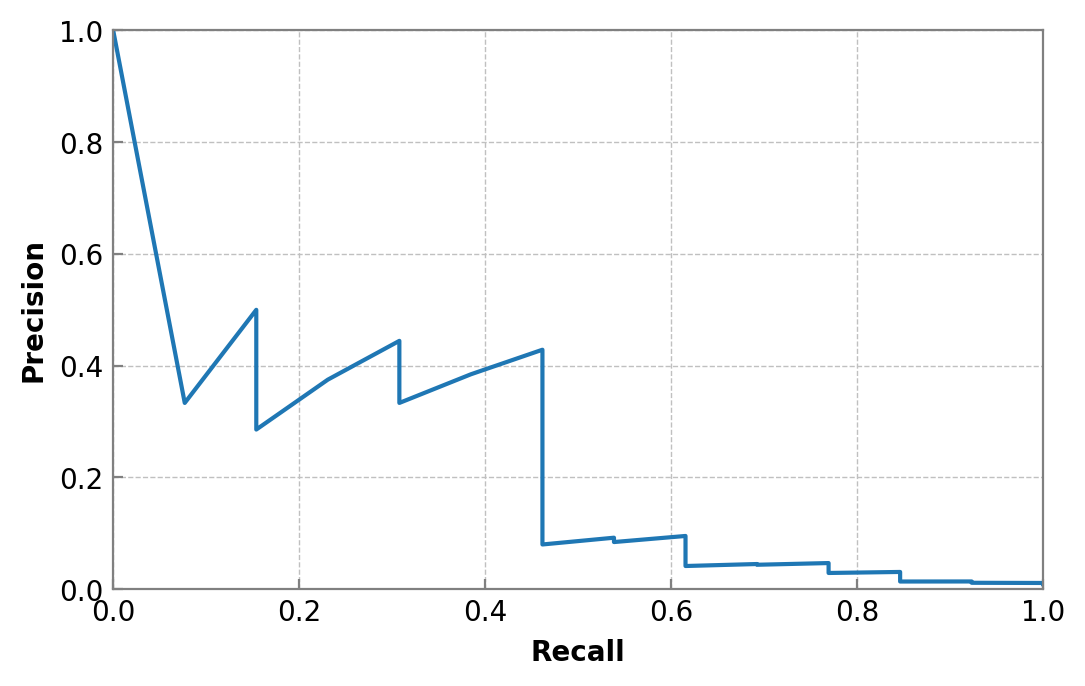

In [59]:
from matplotlib import pyplot as plt

ps, rs, ths = ([], [], [])
th = np.max(pred_es)
while th >= 0.0:
    p, r = pr_at_th(th)
    if p > 0:
        ps.append(p)
        rs.append(r)
    else:
        ps.append(1.0)
        rs.append(0.0)
    ths.append(th)
    th -= 0.0005
    
from sklearn import metrics

print(f'AUC: {metrics.auc(rs, ps)}, max R: {max(rs)}, max P: {max(ps)}')
    
i = len(rs) - 1
while rs[i] == 1.0:
    i -= 1
i += 1
print(f'100% recall at: {int(ps[i] * 100)}%, threshold: {ths[i]}')

fig, ax = plt.subplots(figsize=(6, 3.7), dpi=200)

ax.spines['top'].set_color('#808080')
ax.spines['right'].set_color('#808080')
ax.spines['left'].set_color('#808080')
ax.spines['bottom'].set_color('#808080')
ax.tick_params(direction='in', color='#808080')

plt.grid(color='#c0c0c0', linestyle='--', linewidth=0.5)

plt.ylabel('Precision', fontweight='bold')
plt.xlabel('Recall', fontweight='bold')

plt.xlim((0.0, 1.0))
plt.ylim((0.0, 1.0))

_ = plt.plot(rs, ps)